# Exercise 2: Decision Trees

In this assignment you will implement a Decision Tree algorithm as learned in class.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
1. Submission includes this notebook only with the exercise number and your ID as the filename. For example: `hw2_123456789_987654321.ipynb` if you submitted in pairs and `hw2_123456789.ipynb` if you submitted the exercise alone.
1. Write **efficient vectorized** code whenever possible. Some calculations in this exercise take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deduction.
1. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
1. Write your functions in this notebook only. **Do not create Python modules and import them**.
1. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) only. **Do not import anything else.**
1. Your code must run without errors. Make sure your `numpy` version is at least 1.15.4 and that you are using at least python 3.6. Changes of the configuration we provided are at your own risk. Any code that cannot run will not be graded.
1. Write your own code. Cheating will not be tolerated.
1. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support). Answers that will be written in commented code blocks will not be checked.

## In this exercise you will perform the following:
1. Practice OOP in python.
2. Implement two impurity measures: Gini and Entropy.
3. Construct a decision tree algorithm.
4. Prune the tree to achieve better results.
5. Visualize your results.

# I have read and understood the instructions: *** 319091039_318339041 ***

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Warmup - OOP in python

Our desicion tree will be implemented using a dedicated python class. Python classes are very similar to classes in Java.


You can use the following [site](https://jeffknupp.com/blog/2014/06/18/improve-your-python-python-classes-and-object-oriented-programming/) to learn about classes in python.

In [2]:
class Node(object):
    def __init__(self, data):
        self.data = data
        self.children = []

    def add_child(self, node):
        self.children.append(node)

In [3]:
n = Node(5)
p = Node(6)
q = Node(7)
n.add_child(p)
n.add_child(q)
n.children

[<__main__.Node at 0x2077383b8e0>, <__main__.Node at 0x20773838130>]

## Data preprocessing

For the following exercise, we will use a dataset containing mushroom data `agaricus-lepiota.csv`. 

This data set includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family. Each species is identified as definitely edible, definitely poisonous, or of unknown edibility and not recommended. This latter class was combined with the poisonous
one (=there are only two classes **edible** and **poisonous**). 
    
The dataset contains 8124 observations with 22 features:
1. cap-shape: bell=b,conical=c,convex=x,flat=f,knobbed=k,sunken=s
2. cap-surface: fibrous=f,grooves=g,scaly=y,smooth=s
3. cap-color: brown=n,buff=b,cinnamon=c,gray=g,green=r,pink=p,purple=u,red=e,white=w,yellow=y
4. bruises: bruises=t,no=f
5. odor: almond=a,anise=l,creosote=c,fishy=y,foul=f, musty=m,none=n,pungent=p,spicy=s
6. gill-attachment: attached=a,descending=d,free=f,notched=n
7. gill-spacing: close=c,crowded=w,distant=d
8. gill-size: broad=b,narrow=n
9. gill-color: black=k,brown=n,buff=b,chocolate=h,gray=g,green=r,orange=o,pink=p,purple=u,red=e,white=w,yellow=y
10. stalk-shape: enlarging=e,tapering=t
11. stalk-root: bulbous=b,club=c,cup=u,equal=e,rhizomorphs=z,rooted=r
12. stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s
13. stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s
14. stalk-color-above-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
15. stalk-color-below-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
16. veil-type: partial=p,universal=u
17. veil-color: brown=n,orange=o,white=w,yellow=y
18. ring-number: none=n,one=o,two=t
19. ring-type: cobwebby=c,evanescent=e,flaring=f,large=l,none=n,pendant=p,sheathing=s,zone=z
20. spore-print-color: black=k,brown=n,buff=b,chocolate=h,green=r,orange=o,purple=u,white=w,yellow=y
21. population: abundant=a,clustered=c,numerous=n,scattered=s,several=v,solitary=y
22. habitat: grasses=g,leaves=l,meadows=m,paths=p,urban=u,waste=w,woods=d

First, we will read and explore the data using pandas and the `.read_csv` method. Pandas is an open source library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.

In [4]:
# load dataset
data = pd.read_csv('agaricus-lepiota.csv')

One of the advantages of the Decision Tree algorithm is that almost no preprocessing is required. However, finding missing values is always required.

In [5]:
#############################################################################
# TODO: Find columns with missing values and remove them from the data.#
#############################################################################
data.dropna(how='any', axis=1, inplace=True)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

We will split the dataset to `Training` and `Testing` datasets.

In [6]:
from sklearn.model_selection import train_test_split
# Making sure the last column will hold the labels
X, y = data.drop('class', axis=1), data['class']
X = np.column_stack([X,y])
# split dataset using random_state to get the same split each time
X_train, X_test = train_test_split(X, random_state=99)
print(X_train.shape[1]-1)
print("Training dataset shape: ", X_train.shape)
print("Testing dataset shape: ", X_test.shape)

21
Training dataset shape:  (6093, 22)
Testing dataset shape:  (2031, 22)


In [7]:
y.shape

(8124,)

## Impurity Measures

Impurity is a measure of how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset. Implement the functions `calc_gini` and `calc_entropy`. You are encouraged to test your implementation (10 points).

In [8]:
def calc_gini(data):
    """
    Calculate gini impurity measure of a dataset.
 
    Input:
    - data: any dataset where the last column holds the labels.
 
    Returns the gini impurity.    
    """
    y = data[:,-1]
    y_len = y.shape[0]
    _,class_count = np.unique(y,return_counts = True)
    gini = 0.0
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    probs = (class_count/y_len)**2
    gini = 1 - probs.sum()
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return gini

In [9]:
def calc_entropy(data):
    """
    Calculate the entropy of a dataset.

    Input:
    - data: any dataset where the last column holds the labels.

    Returns the entropy of the dataset.    
    """
    entropy = 0.0
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    y = data[:,-1]
    y_len = y.shape[0]
    _,class_count = np.unique(y,return_counts = True)
    probs = (class_count/y_len)
    probs = probs*np.log2(probs, out=np.zeros_like(probs), where =(probs!= 0))
    entropy -= probs.sum()
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return entropy

In [10]:
##### Your Tests Here #####
calc_gini(X), calc_entropy(X)

(0.4995636322379775, 0.9993703627906085)

## Goodness of Split

Given a feature the Goodnees of Split measures the reduction in the impurity if we split the data according to the feature.
$$
\Delta\varphi(S, A) = \varphi(S) - \sum_{v\in Values(A)} \frac{|S_v|}{|S|}\varphi(S_v)
$$

In our implementation the goodness_of_split function will return either the Goodness of Split or the Gain Ratio as learned in class. You'll control the return value with the `gain_ratio` parameter. If this parameter will set to False (the default value) it will return the regular Goodness of Split. If it will set to True it will return the Gain Ratio.
$$
GainRatio(S,A)=\frac{InformationGain(S,A)}{SplitInformation(S,A)}
$$
Where:
$$
InformationGain(S,A)=Goodness\ of\ Split\ calculated\ with\ Entropy\ as\ the\ Impurity\ function \\
SplitInformation(S,A)=- \sum_{a\in A} \frac{|S_a|}{|S|}\log\frac{|S_a|}{|S|}
$$
NOTE: you can add more parameters to the function and you can also add more returning variables (The given parameters and the given returning variable should not be touch). (10 Points)

In [11]:
def goodness_of_split(data, feature, impurity_func, gain_ratio=False):
    """
    Calculate the goodness of split of a dataset given a feature and impurity function.

    Input:
    - data: any dataset where the last column holds the labels.
    - feature: the feature index.
    - impurity func: a function that calculates the impurity.
    - gain_ratio: goodness of split or gain ratio flag.

    Returns the goodness of split (or the Gain Ration). 
    """
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    data_imp = 0.0
    feat =data[:,feature]
    vals,val_count = np.unique(feat,return_counts = True)
    feat_len = feat.shape[0]
    probs = (val_count/feat_len)
    if not gain_ratio:
        data_imp = impurity_func(data)
        feat_val = np.column_stack([feat,data[:,-1]])
        i = 0
        for value in vals:
            mask = feat_val[feat_val[:, 0] == value, :]
            probs[i] = probs[i]*impurity_func(mask)
            i += 1
        goodness = data_imp - probs.sum()
    else:
        inform_gain = goodness_of_split(data, feature, calc_entropy, False)
        X = np.column_stack([data, data[:,feature]])
        split_info = calc_entropy(X)
        if split_info == 0:
            goodness = 0
        else:    
            goodness = inform_gain / split_info
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    
    return goodness   

## Building a Decision Tree

Use a Python class to construct the decision tree. Your class should support the following functionality:

1. Initiating a node for a decision tree. You will need to use several class methods and class attributes and you are free to use them as you see fit. We recommend that every node will hold the feature and value used for the split and its children.
2. Your code should support both Gini and Entropy as impurity measures. 
3. The provided data includes categorical data. In this exercise, when splitting a node create the number of children needed according to the attribute unique values.

Complete the class `DecisionNode`. The structure of this class is entirely up to you. 

Complete the function `build_tree`. This function should get the training dataset and the impurity as inputs, initiate a root for the decision tree and construct the tree according to the procedure you learned in class. (30 points)

In [12]:
class DecisionNode:
    """
    This class will hold everything you require to construct a decision tree.
    The structure of this class is up to you. However, you need to support basic 
    functionality as described above. It is highly recommended that you 
    first read and understand the entire exercise before diving into this class.
    """
    def __init__(self, feature, value):
        self.feature = feature # column index of criteria being tested
        self.value = value
        self.children = []
        self.pred = None
        self.val_count = {}
        
        
    def add_child(self, node):
        self.children.append(node)
    

In [13]:
def build_tree(data, impurity, gain_ratio=False, min_samples_split=1, max_depth=1000):
    """
    Build a tree using the given impurity measure and training dataset. 
    You are required to fully grow the tree until all leaves are pure. 

    Input:
    - data: the training dataset.
    - impurity: the chosen impurity measure. Notice that you can send a function
                as an argument in python.
    - gain_ratio: goodness of split or gain ratio flag
    - min_samples_split: the minimum number of samples required to split an internal node
    - max_depth: the allowable depth of the tree

    Output: the root node of the tree.
    """
    root = DecisionNode(None,None)
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    split_node(data, impurity, root, gain_ratio, min_samples_split, max_depth)
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return root

def split_node(data, impurity, node, gain_ratio, min_samples_split, max_depth):
    
    predict_node(data,node)
    
    if ((data.shape[0] <= min_samples_split) or (max_depth == 0) or (impurity(data) == 0)):
        return None
    
    best_feature, goodness = find_best_feature(data, impurity, gain_ratio)
    
    if  goodness <= 0:
        return None
    
    vals,_ = np.unique(data[:,best_feature],return_counts = True)
    node.feature = best_feature
    build_childs(vals,node,best_feature)
    
    for child in node.children:
        new_data = data[data[:, best_feature] == child.value, :]
        split_node(new_data, impurity, child, gain_ratio, min_samples_split, max_depth-1)
    return None
    
def predict_node(data,node):            
    vals, counts = np.unique(data.T[-1], return_counts=True)
    node.val_count = dict(zip(vals,counts))
    node.pred = max(node.val_count, key=node.val_count.get)
    return None

def find_best_feature(data, impurity, gain_ratio):
    best_feature = -1
    goodness = 0
    max_goodness = 0
    for i in range(data.shape[1]-1):             
        goodness = goodness_of_split(data, i, impurity, gain_ratio)
        if goodness >= max_goodness:
            best_feature = i
            max_goodness = goodness
    return best_feature,max_goodness

def build_childs(vals,node,best_feature):                  
    for value in vals:
        child = DecisionNode(None,value)
        node.add_child(child)
    return None

In [14]:
# python supports passing a function as an argument to another function.
tree_gini = build_tree(data=X_train, impurity=calc_gini) # gini and goodness of split
tree_entropy = build_tree(data=X_train, impurity=calc_entropy) # entropy and goodness of split
tree_entropy_gain_ratio = build_tree(data=X_train, impurity=calc_entropy, gain_ratio=True) # entropy and gain ratio


## Tree evaluation

Complete the functions `predict` and `calc_accuracy`. (10 points)

In [15]:
def predict(node, instance):
    """
    Predict a given instance using the decision tree
 
    Input:
    - root: the root of the decision tree.
    - instance: an row vector from the dataset. Note that the last element 
                of this vector is the label of the instance.
 
    Output: the prediction of the instance.
    """
    pred = None
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    current_node = node
    instance_val = 0 
    while(True):
        if current_node.pred != None:
            pred = current_node.pred
        if current_node.children == []:
            break
        current_feat = current_node.feature
        instance_val = instance[current_feat]
        flag = False
        for child in current_node.children:
            if instance_val == child.value:
                current_node = child
                flag = True
        if not flag:
            return current_node.pred
            break
    return pred 
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

In [16]:
def calc_accuracy(node, dataset):
    """
    Predict a given dataset using the decision tree
 
    Input:
    - node: a node in the decision tree.
    - dataset: the dataset on which the accuracy is evaluated
 
    Output: the accuracy of the decision tree on the given dataset (%).
    """
    accuracy = 0.0
    success = 0
    tries= 0
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    for row in dataset:
        label = row[-1]
        pred = predict(node,row[:len(row) - 1])
        if pred == label:
            success +=1
        tries+=1
    accuracy = success / tries
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return accuracy * 100

After building the three trees using the training set, you should calculate the accuracy on the test set. For each tree print the training and test accuracy. Select the tree that gave you the best test accuracy. For the rest of the exercise, use that tree (when you asked to build another tree use the same impurity function and same gain_ratio flag). 

In [17]:
#### Your code here ####
calc_accuracy_tree_gini = calc_accuracy(tree_gini,X_test)
calc_accuracy_tree_entropy = calc_accuracy(tree_entropy,X_test)
calc_accuracy_tree_entropy_gain_ratio = calc_accuracy(tree_entropy_gain_ratio,X_test)
calc_accuracy_tree_gini_train = calc_accuracy(tree_gini,X_train)
calc_accuracy_tree_entropy_train = calc_accuracy(tree_entropy,X_train)
calc_accuracy_tree_entropy_gain_ratio_train = calc_accuracy(tree_entropy_gain_ratio,X_train)
print("we get:",calc_accuracy_tree_gini,"% when we use build_tree with testing data, calc_gini and the default values.")
print("we get:",calc_accuracy_tree_entropy,"% when we use build_tree with testing data, calc_entropy and the default values.")
print("\nwe get:",calc_accuracy_tree_entropy_gain_ratio,"% when we use build_tree with testing data, calc_entropy, gain_ratio=True and the default values. this is the most accurate.\n")
print("we get:",calc_accuracy_tree_gini_train,"% when we use build_tree with training data, calc_gini and the default values.")
print("we get:",calc_accuracy_tree_entropy_train,"% when we use build_tree with training data, calc_entropy and the default values.")
print("we get:",calc_accuracy_tree_entropy_gain_ratio_train,"% when we use build_tree with training data, calc_entropy, gain_ratio=True and the default values.")

we get: 78.38503200393895 % when we use build_tree with testing data, calc_gini and the default values.
we get: 78.04037419990154 % when we use build_tree with testing data, calc_entropy and the default values.

we get: 78.68045297882816 % when we use build_tree with testing data, calc_entropy, gain_ratio=True and the default values. this is the most accurate.

we get: 99.21221073362875 % when we use build_tree with training data, calc_gini and the default values.
we get: 99.37633349745609 % when we use build_tree with training data, calc_entropy and the default values.
we get: 99.67175447234531 % when we use build_tree with training data, calc_entropy, gain_ratio=True and the default values.


## Depth pruning

(15 points)

Consider the following max_depth values: [1, 2, 3, 4, 5, 6, 7, 8]. For each value, construct a tree and prune it according to the max_depth value = don't let the tree to grow beyond this depth. Next, calculate the training and testing accuracy.<br>
On a single plot, draw the training and testing accuracy as a function of the max_depth. Mark the best result on the graph with red circle.

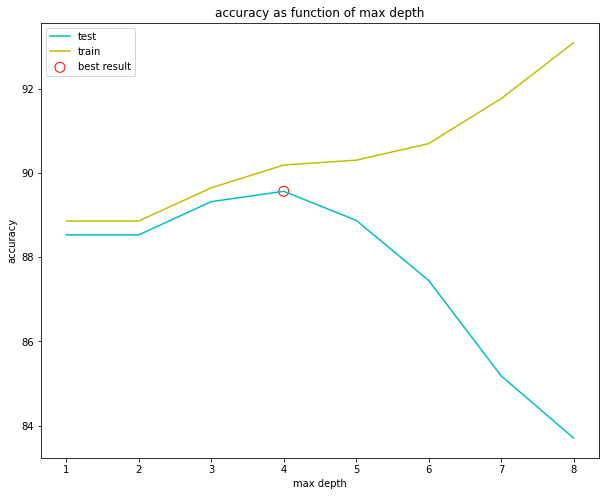

In [18]:
max_depth_arr = [1,2,3,4,5,6,7,8]
d_root_arr = []
d_acc_train_arr = []
d_acc_test_arr = []
for depth in max_depth_arr:
    d_root_arr.append(build_tree(X_train,calc_entropy , True, 1, depth))
for root in d_root_arr:
    d_acc_test_arr.append(calc_accuracy(root,X_test))
    d_acc_train_arr.append(calc_accuracy(root,X_train))
max_index = np.argmax(d_acc_test_arr)



plt.plot(max_depth_arr, d_acc_test_arr,'c', label = "test")
plt.plot(max_depth_arr, d_acc_train_arr, 'y', label = "train")
plt.scatter(max_depth_arr[max_index], d_acc_test_arr[max_index], s=100, facecolors='none', edgecolors='r',label = "best result")
plt.legend(loc = 'upper left')
plt.xlabel('max depth')
plt.ylabel('accuracy')
plt.title('accuracy as function of max depth')
plt.show()

## Min Samples Split

(15 points)

Consider the following min_samples_split values: [1, 5, 10, 20, 50]. For each value, construct a tree and prune it according to the min_samples_split value = don't split a node if the number of sample in it is less or equal to the min_samples_split value. Next, calculate the training and testing accuracy.<br>
On a single plot, draw the training and testing accuracy as a function of the min_samples_split. Mark the best result on the graph with red circle. (make sure that the x-axis ticks represent the values of min_samples_split)

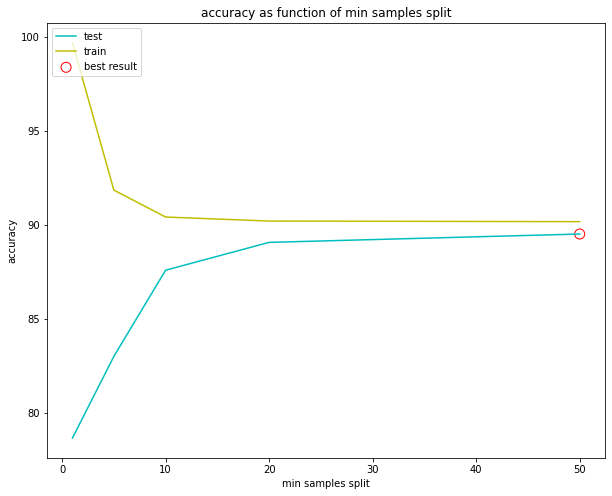

In [19]:
#### Your code here ####
min_samples_split_arr = [1, 5, 10, 20, 50]
m_root_arr = []
m_acc_test_arr = []
m_acc_train_arr = []
for sample in min_samples_split_arr:
    m_root_arr.append(build_tree(X_train,calc_entropy , True, sample))
    
for root in m_root_arr:
    m_acc_test_arr.append(calc_accuracy(root,X_test))
    m_acc_train_arr.append(calc_accuracy(root,X_train))
    
max_index = np.argmin(m_acc_train_arr)

plt.plot(min_samples_split_arr, m_acc_test_arr,'c', label = "test")
plt.plot(min_samples_split_arr, m_acc_train_arr, 'y', label = "train")
plt.scatter(min_samples_split_arr[max_index], m_acc_test_arr[max_index], s=100, facecolors='none', edgecolors='r',label = "best result")
plt.legend(loc = 'upper left')
plt.xlabel('min samples split')
plt.ylabel('accuracy')
plt.title('accuracy as function of min samples split')
plt.show()


Build the best 2 trees:
1. tree_max_depth - the best tree according to max_depth pruning
1. tree_min_samples_split - the best tree according to min_samples_split pruning

In [21]:
index1 = np.argmax(d_acc_test_arr)
tree_max_depth = d_root_arr[index1] 
index2 = np.argmax(m_acc_test_arr)
tree_min_samples_split  = m_root_arr[index2] 

print("test accuracy for best max_depth: ", d_acc_test_arr[index1])
print("test accuracy for best min_samples_split: ", m_acc_test_arr[index2])

test accuracy for best max_depth:  89.561792220581
test accuracy for best min_samples_split:  89.51255539143278


## Number of Nodes

(5 points)

Complete the function counts_nodes and print the number of nodes in each tree and print the number of nodes of the two trees above

In [22]:
def count_nodes(node):
    """
    Count the number of node in a given tree
 
    Input:
    - node: a node in the decision tree.
 
    Output: the number of node in the tree.
    """

    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    if node.children == []:
        return 1
    counter = 1
    for child in node.children:
        counter +=  count_nodes(child)
    
    return counter

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    

## Print the tree

Complete the function `print_tree`. Your tree should be visualized clearly. You can use the following example as a reference:
```
[ROOT, feature=X0],
  [X0=a, feature=X2]
    [X2=c, leaf]: [{1.0: 10}]
    [X2=d, leaf]: [{0.0: 10}]
  [X0=y, feature=X5], 
    [X5=a, leaf]: [{1.0: 5}]
    [X5=s, leaf]: [{0.0: 10}]
  [X0=e, leaf]: [{0.0: 25, 1.0: 50}]
```
In each brackets:
* The first argument is the parent feature with the value that led to current node
* The second argument is the selected feature of the current node
* If the current node is a leaf, you need to print also the labels and their counts

(5 points)

In [23]:
# you can change the function signeture
def print_tree(node, depth=0, parent_feature='ROOT', feature_val='ROOT'):
    '''
    prints the tree according to the example above

    Input:
    - node: a node in the decision tree

    This function has no return value
    '''
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    prev_feat = node.feature
    space = 2*depth 
    if node.value == None:
        print(" "*space,"[",parent_feature,", feature=",node.feature,"]\n")
    elif node.children==[]:
        print(" "*space,"[",parent_feature,"=",node.value,",leaf] [", node.val_count,"]\n")
        return 
    else:
        print(" "*space,"[",parent_feature,"=",node.value,", feature=",node.feature,"]\n")
    for child in node.children:
        print_tree(child,depth+1,node.feature,child.value)
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################


    
    


print the tree with the best test accuracy and with less than 50 nodes (from the two pruning methods)

In [24]:
#### Your code here ####
max_depth_arr = [1,2,3,4,5,6,7,8]
min_samples_split_arr = [1, 5, 10, 20, 50]
best_root_arr = []
acc_test_arr = []
for depth in max_depth_arr:
    for sample in min_samples_split_arr:
        best_root_arr.append(build_tree(X_train,calc_entropy , True , sample, depth))
for root in best_root_arr:
    acc_test_arr.append(calc_accuracy(root,X_test))
max_arc = 0
index = 0
best_tree = None
for node in best_root_arr:
    if count_nodes(node) <= 50:
        if max_arc <  acc_test_arr[index]:
            max_arc = acc_test_arr[index]
            best_tree = node
    index += 1

print(count_nodes(best_tree), max_arc)
print_tree(best_tree)


10 88.52781880846874
 [ ROOT , feature= 4 ]

   [ 4 = a ,leaf] [ {'e': 273, 'p': 31} ]

   [ 4 = c ,leaf] [ {'e': 10, 'p': 137} ]

   [ 4 = f ,leaf] [ {'e': 170, 'p': 1438} ]

   [ 4 = l ,leaf] [ {'e': 272, 'p': 27} ]

   [ 4 = m ,leaf] [ {'e': 2, 'p': 25} ]

   [ 4 = n ,leaf] [ {'e': 2332, 'p': 344} ]

   [ 4 = p ,leaf] [ {'e': 8, 'p': 175} ]

   [ 4 = s ,leaf] [ {'e': 38, 'p': 380} ]

   [ 4 = y ,leaf] [ {'e': 49, 'p': 382} ]

